# ManTra-Net: Manipulation Tracing Network For Detection and Localization of Image Forgeries With Anomalous Features

## This is a simple demonstrative notebook for the pretrained ManTra-Net

## Note:

- Please make sure you run this notebook with the GPU support. You may see tensorflow errors when decoding images of very large sizes, e.g. 2048x3072.
- All lib/data paths used in this notebook is relative. In case you run this notebook outside of its original location, please fix the data paths.

# 1. Download the ManTraNet Repo

In [ ]:
#!pip install tensorflow==1.14

In [ ]:
!pip3 uninstall keras-nightly
#!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

In [ ]:
!rm -rf ManTraNet
!git clone https://github.com/ISICV/ManTraNet.git


Cloning into 'ManTraNet'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 211 (delta 4), reused 2 (delta 0), pack-reused 202
Receiving objects: 100% (211/211), 140.00 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
#!pip3 uninstall keras==2.2.4

# 2. Import Dependent Libs and Set Paths

In [ ]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:
manTraNet_root = '/content/ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

# 3. Load Sample Data 

In [ ]:
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

INFO: in total, load 72 samples


# 4. Load A Pretrained ManTraNet Model

In [ ]:
import modelCore
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

In [ ]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

In [ ]:
manTraNet.layers[1].summary()

In [ ]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

# 5. Play With The Provided Sample Data

## Note: we don't need original image files for forgery detection. They are included here to demonstrate the effectiveness of the ManTra-Net.


In [ ]:
from datetime import datetime 
def read_rgb_image( image_file ) :
    rgb = cv2.imread( image_file, 1 )[...,::-1]
    return rgb
    
def decode_an_image_array( rgb, manTraNet, dn=1 ) :
    x = np.expand_dims( rgb.astype('float32')/255.*2-1, axis=0 )[:,::dn,::dn]
    t0 = datetime.now()
    y = manTraNet.predict(x)[0,...,0]
    t1 = datetime.now()
    return y, t1-t0

def decode_an_image_file( image_file, manTraNet, dn=1 ) :
    rgb = read_rgb_image( image_file )
    mask, ptime = decode_an_image_array( rgb, manTraNet, dn )
    return rgb[::dn,::dn], mask, ptime.total_seconds()

In [ ]:
def get_image_from_direc(direc, xrange=None, yrange=None, dn=1) :
    img = cv2.cvtColor(cv2.imread(direc), cv2.COLOR_BGR2RGB)
    #original_file = 
    rgb = read_rgb_image(direc)
    img = np.array(img)
    if img.shape[-1] > 3 :
        img = img[...,:3]
    ori = np.array(img)
    if xrange is not None :
        img = img[:,xrange[0]:xrange[1]]
    if yrange is not None :
        img = img[yrange[0]:yrange[1]]
    mask, ptime =  decode_an_image_array( img, manTraNet, dn )
    ptime = ptime.total_seconds()
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.title('Original Image')
    pyplot.subplot(131)
    pyplot.imshow( img )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(132)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.subplot(133)
    pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
    pyplot.title('Highlighted Forged Regions')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( direc, rgb.shape, ptime ) )
    pyplot.show()

In [ ]:
get_image_from_direc('/content/Sample_Data/0_rgb.png')

In [ ]:
!unzip Sample_Data.zip

In [ ]:
from google.colab.patches import cv2_imshow

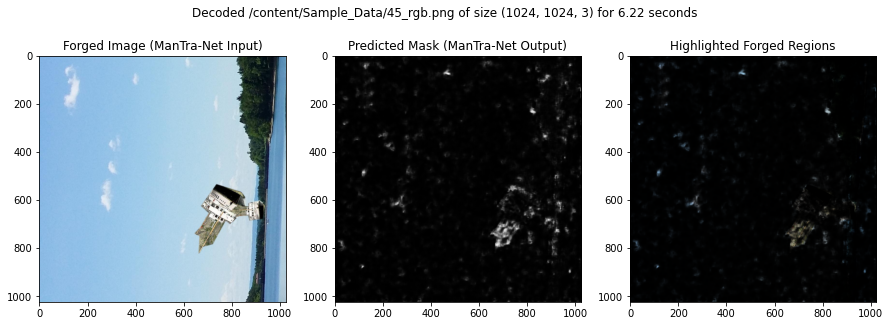

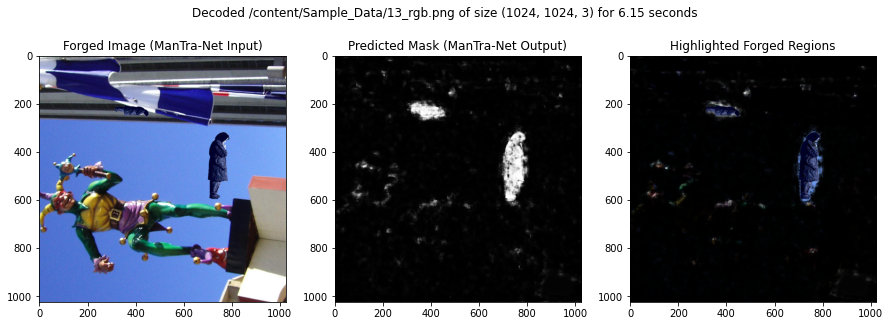

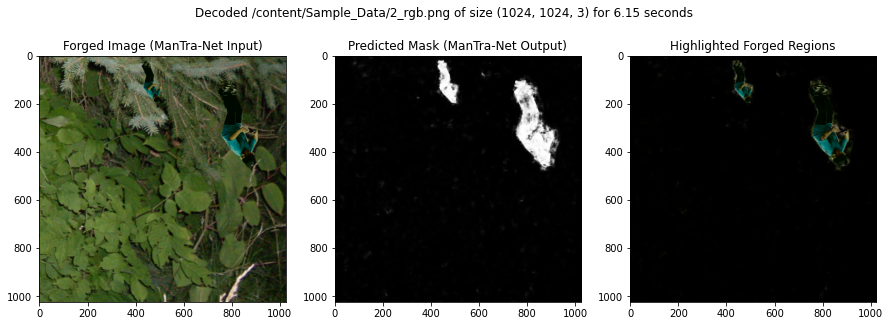

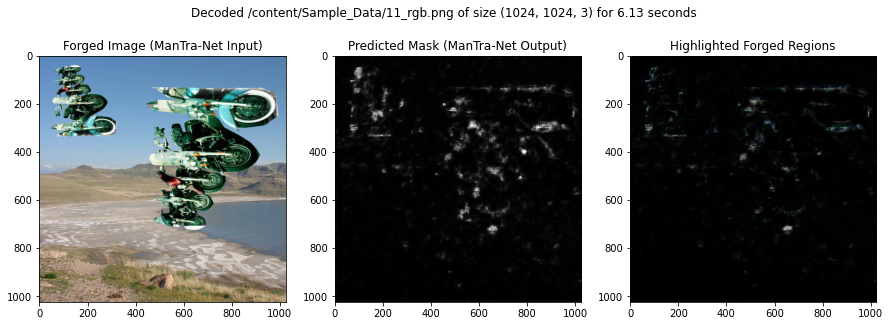

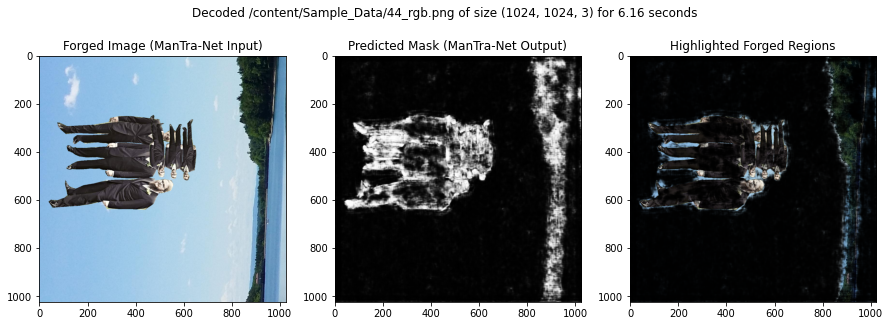

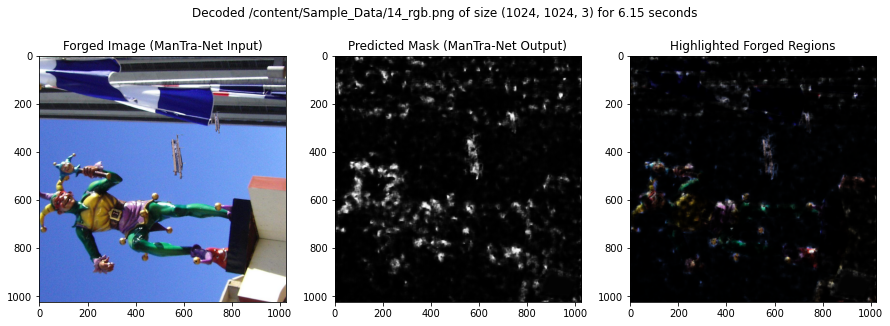

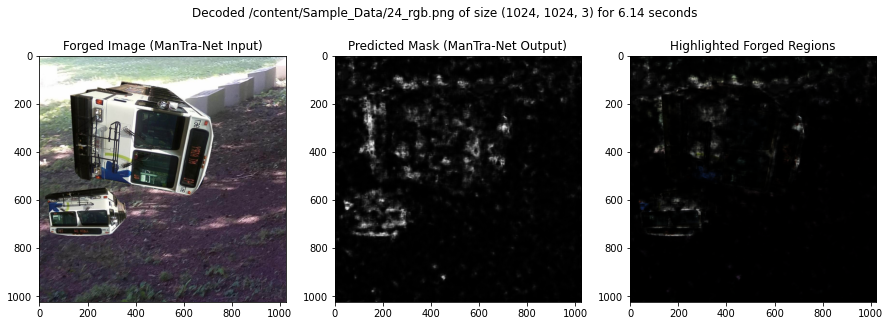

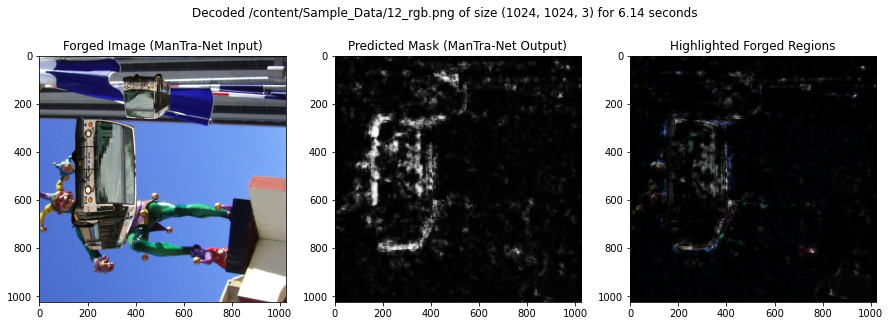

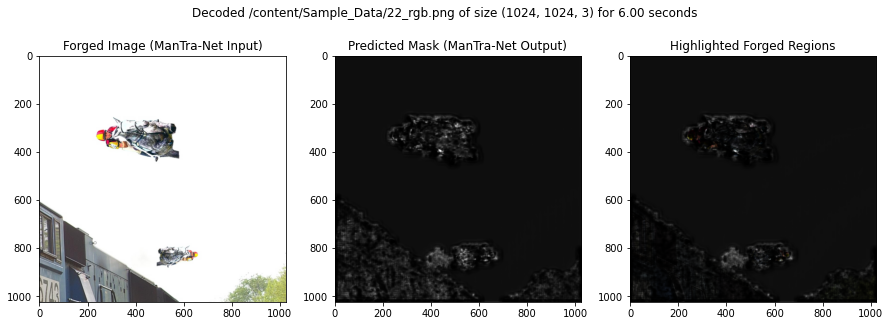

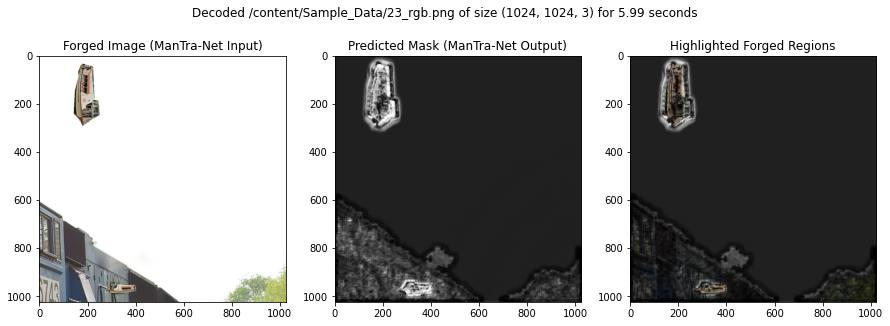

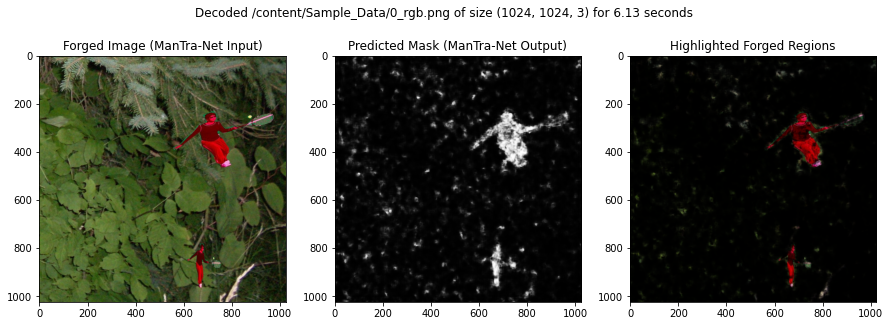

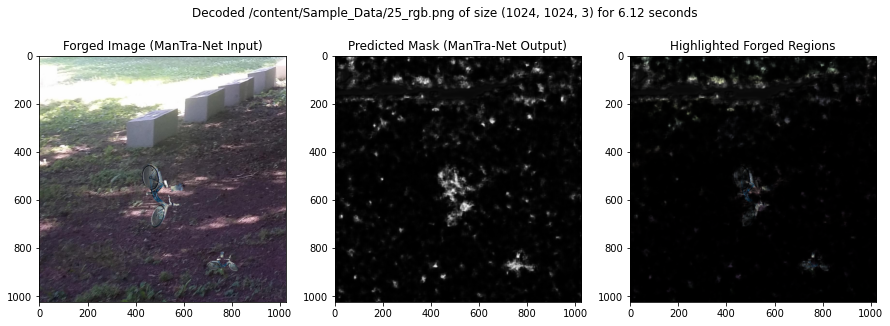

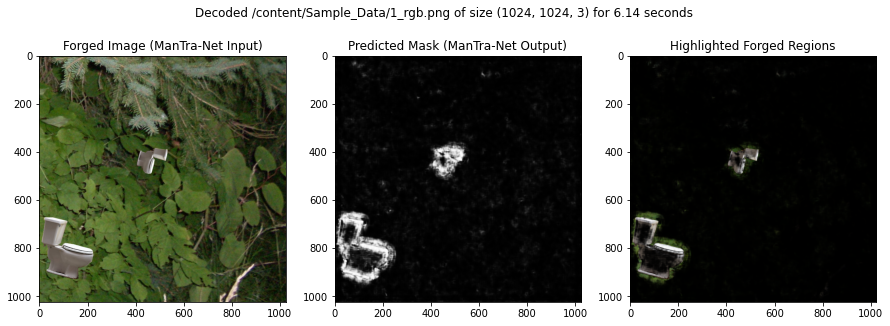

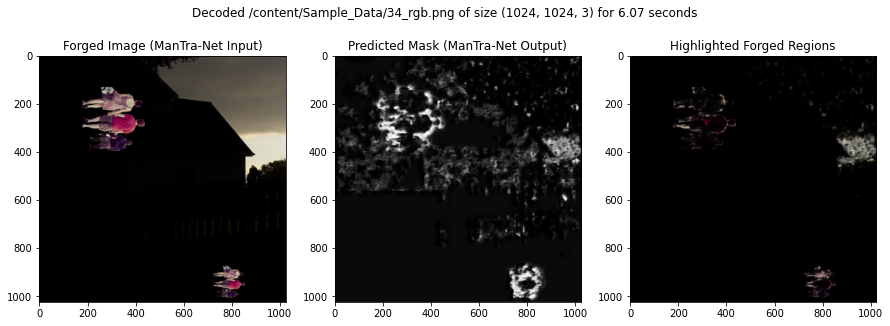

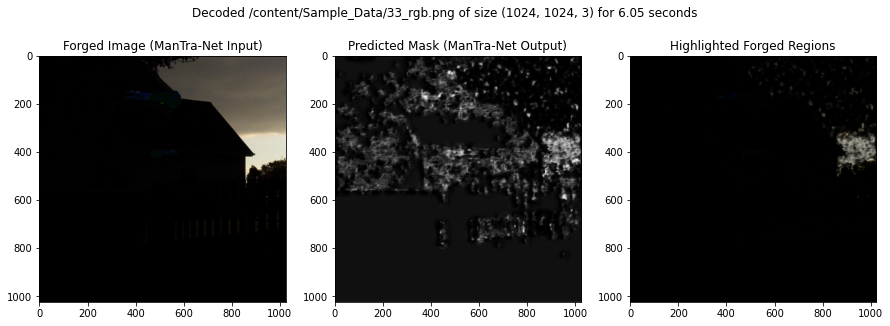

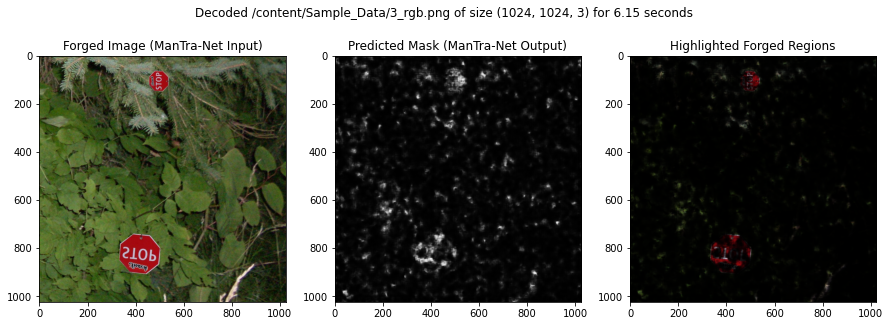

In [ ]:
direc = '/content/'
direc = os.path.join(direc,'Sample_Data/')
for filename in os.listdir(direc):
    #print(filename)
    #if filename.endswith("jpg"):
    #cv2_imshow(filename)
    #print(direc)
    direct = os.path.join(direc,filename)
    #print(direct) 
    get_image_from_direc(direct)

In [ ]:
for k in range(8) :
    # get a sample
    forged_file, original_file = get_a_random_pair()
    # load the original image just for reference
    ori = read_rgb_image( original_file )
    # manipulation detection using ManTraNet
    rgb, mask, ptime = decode_an_image_file( forged_file, manTraNet ) 
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.subplot(131)
    pyplot.imshow( ori )
    pyplot.title('Original Image')
    pyplot.subplot(132)
    pyplot.imshow( rgb )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(133)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( os.path.basename( forged_file ), rgb.shape, ptime ) )
    pyplot.show()

# 6. Play with Internet Data

### Note: Internet images are often compressed and/or resized, and this means subtle manipulations will be much more difficult to detect after such postprocessing. 

### Therefore, don't be surprised if you see ManTraNet fails on some sample. 


In [ ]:
def get_image_from_url(url, xrange=None, yrange=None, dn=1) :
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    if img.shape[-1] > 3 :
        img = img[...,:3]
    ori = np.array(img)
    if xrange is not None :
        img = img[:,xrange[0]:xrange[1]]
    if yrange is not None :
        img = img[yrange[0]:yrange[1]]
    rgb, mask, ptime =  decode_an_image_file( img, manTraNet, dn )
    ptime = ptime.total_seconds()
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.title('Original Image')
    pyplot.subplot(131)
    pyplot.imshow( img )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(132)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.subplot(133)
    pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
    pyplot.title('Highlighted Forged Regions')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
    pyplot.show()
    

In [ ]:
get_image_from_url('https://i.imgur.com/2gS6lgL.png')

In [ ]:
ls

ManTraNet/  sample_data/


In [ ]:
img = cv2.cvtColor(cv2.imread('71I6JAJA7rL..jpg'), cv2.COLOR_BGR2RGB)
dn = 1
if img.shape[-1] > 3 :
    img = img[...,:3]
ori = np.array(img)
mask, ptime =  decode_an_image_array( img, manTraNet, dn )
ptime = ptime.total_seconds()
# show results
pyplot.figure( figsize=(15,5) )
pyplot.title('Original Image')
pyplot.subplot(131)
pyplot.imshow( img )
pyplot.title('Forged Image (ManTra-Net Input)')
pyplot.subplot(132)
pyplot.imshow( mask, cmap='gray' )
pyplot.title('Predicted Mask (ManTra-Net Output)')
pyplot.subplot(133)
pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
pyplot.title('Highlighted Forged Regions')
pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
pyplot.show()

error: ignored

In [ ]:
img = cv2.cvtColor(cv2.imread('61j5jxk4mVL..jpg'), cv2.COLOR_BGR2RGB)
dn = 1
if img.shape[-1] > 3 :
    img = img[...,:3]

ori = np.array(img)
mask, ptime =  decode_an_image_array( img, manTraNet, dn )
ptime = ptime.total_seconds()
# show results
pyplot.figure( figsize=(15,5) )
pyplot.title('Original Image')
pyplot.subplot(131)
pyplot.imshow( img )
pyplot.title('Forged Image (ManTra-Net Input)')
pyplot.subplot(132)
pyplot.imshow( mask, cmap='gray' )
pyplot.title('Predicted Mask (ManTra-Net Output)')
pyplot.subplot(133)
pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
pyplot.title('Highlighted Forged Regions')
pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
pyplot.show()

error: ignored

NameError: ignored

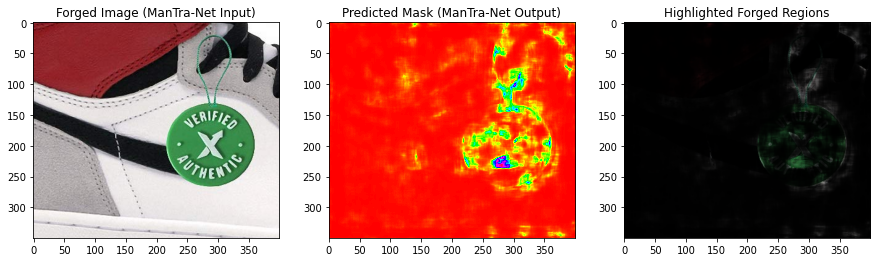

In [ ]:
img = cv2.cvtColor(cv2.imread('61j5jxk4mVL..jpg'), cv2.COLOR_BGR2RGB)
dn = 1
if img.shape[-1] > 3 :
    img = img[...,:3]
xrange = [150, 550]
yrange = [200, 550]
if xrange is not None :
    img = img[:,xrange[0]:xrange[1]]
if yrange is not None :
    img = img[yrange[0]:yrange[1]]
ori = np.array(img)
mask, ptime =  decode_an_image_array( img, manTraNet, dn )
ptime = ptime.total_seconds()
# show results
pyplot.figure( figsize=(15,5) )
pyplot.title('Original Image')
pyplot.subplot(131)
pyplot.imshow( img )
pyplot.title('Forged Image (ManTra-Net Input)')
pyplot.subplot(132)
pyplot.imshow( mask, cmap='hsv' )
pyplot.title('Predicted Mask (ManTra-Net Output)')
pyplot.subplot(133)
pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
pyplot.title('Highlighted Forged Regions')
pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
pyplot.show()

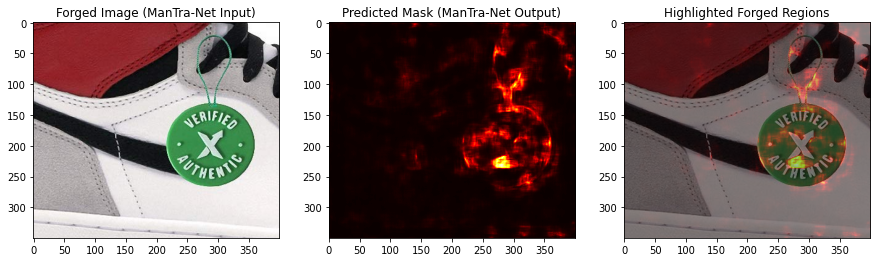

In [ ]:
# show results
pyplot.figure( figsize=(15,5) )
pyplot.title('Original Image')
pyplot.subplot(131)
pyplot.imshow( img )
pyplot.title('Forged Image (ManTra-Net Input)')
pyplot.subplot(132)
pyplot.imshow( mask, cmap='hot' )
pyplot.title('Predicted Mask (ManTra-Net Output)')
pyplot.subplot(133)
pyplot.imshow( img )
pyplot.imshow( mask, cmap='hot', alpha=0.5 )
pyplot.title('Highlighted Forged Regions')
pyplot.show()

NameError: ignored

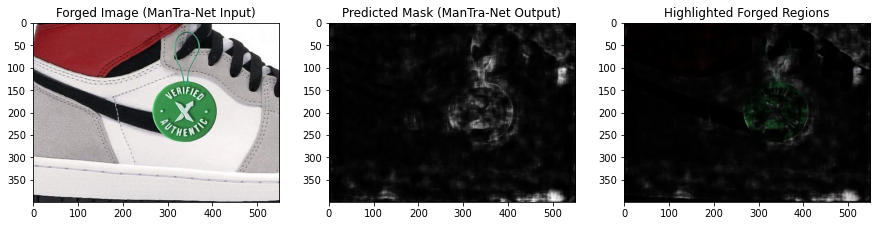

In [ ]:
img = cv2.cvtColor(cv2.imread('61j5jxk4mVL..jpg'), cv2.COLOR_BGR2RGB)
dn = 1
if img.shape[-1] > 3 :
    img = img[...,:3]
xrange = [100, 650]
yrange = [200, 600]
if xrange is not None :
    img = img[:,xrange[0]:xrange[1]]
if yrange is not None :
    img = img[yrange[0]:yrange[1]]
ori = np.array(img)
mask, ptime =  decode_an_image_array( img, manTraNet, dn )
ptime = ptime.total_seconds()
# show results
pyplot.figure( figsize=(15,5) )
pyplot.title('Original Image')
pyplot.subplot(131)
pyplot.imshow( img )
pyplot.title('Forged Image (ManTra-Net Input)')
pyplot.subplot(132)
pyplot.imshow( mask, cmap='gray' )
pyplot.title('Predicted Mask (ManTra-Net Output)')
pyplot.subplot(133)
pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
pyplot.title('Highlighted Forged Regions')
pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
pyplot.show()

In [ ]:
get_image_from_url('https://www.google.com/imgres?imgurl=https%3A%2F%2Fi.pinimg.com%2Foriginals%2F95%2F35%2F11%2F953511e21d0f2b0880777ac354f3f90e.jpg&imgrefurl=https%3A%2F%2Fwww.pinterest.com%2Fpin%2F624874517029068504%2F&tbnid=L1rY7mmOiwIUOM&vet=12ahUKEwjGgKXK2rPyAhVyFLcAHXmKDQoQMygFegUIARDQAQ..i&docid=z0goDz2-9TIuyM&w=2048&h=2560&q=edited%20images&ved=2ahUKEwjGgKXK2rPyAhVyFLcAHXmKDQoQMygFegUIARDQAQ')

UnidentifiedImageError: ignored

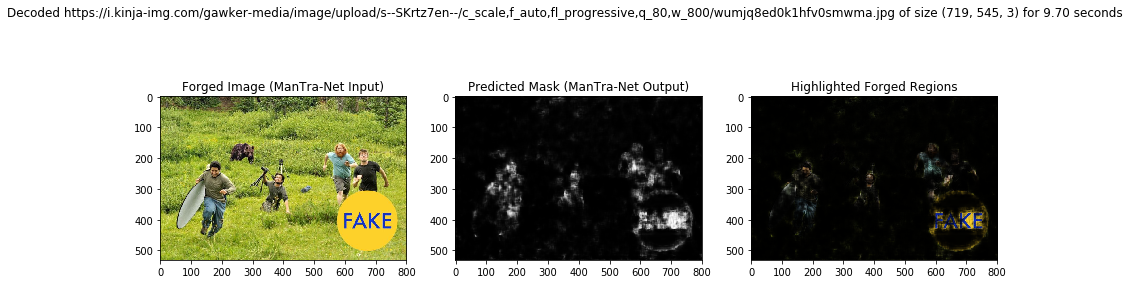

In [ ]:
get_image_from_url('https://i.kinja-img.com/gawker-media/image/upload/s--SKrtz7en--/c_scale,f_auto,fl_progressive,q_80,w_800/wumjq8ed0k1hfv0smwma.jpg')